# Notebook overview

## Goals

- word2vec training
    - Train a word2vec model on the lemmatized sentences dataset
- Feature creation
    - Create binary sentiment labels for each review based on number of stars
- Encoding
    - Encode the lemmatized text data as sequences of word embeddings using the word2vec model
    - Encode sentiment labels as one-hot vectors

## Data

### Interim

- Derived from Yelp review dataset (https://www.yelp.com/dataset)
- Generated in previous notebook, accessible from kaggle as `yelp-dataset-reviews-nlp` (https://www.kaggle.com/datasets/gabrielmadigan/yelp-dataset-reviews-nlp)
- Specifically, I analyze the `/data/interim/lemmatized-data.json` and `/data/interim/lemmatized-sentences.json` files which have been prepared for this module following inspection, cleaning, reduction, tokenization, and lemmatization of the raw Yelp dataset (see below).

### Raw

- Yelp review dataset (https://www.yelp.com/dataset)
- Accessible from kaggle as `yelp-dataset` (https://www.kaggle.com/datasets/yelp-dataset/yelp-dataset)
- Description from the kaggle dataset page:
> This dataset is a subset of Yelp's businesses, reviews, and user data. It was originally put together for the Yelp Dataset Challenge which is a chance for students to conduct research or analysis on Yelp's data and share their discoveries. In the most recent dataset you'll find information about businesses across 8 metropolitan areas in the USA and Canada.
- Specifically, I analyze the `yelp_academic_dataset_review.json` file which contains data pertaining to Yelp user reviews and includes the text of the review and an associated 1-5 star rating of the Yelp user's experience (among other data, e.g., date, business ID, etc.)


## Libraries

- `NumPy` - a fundamental Python package for perfroming scientific analysis and computation, used to transform data (https://numpy.org/)
- `Pandas` - used to read, load, store, inspect, process, and save the data (https://pandas.pydata.org/)
- `Gensim` - a great library for training NLP models, used for encoding the text data into vectors with word2vec (https://radimrehurek.com/gensim/)

## Output

- `/kaggle/working/figures/token-counts.pdf` - a plot showing the number of reviews with a given token count in the dataset
- `/kaggle/working/data/processed/encoded-data.json` - contains the reviews encoded as sequences of word embeddings and their corresponding one-hot encoded class labels
- `/kaggle/working/data/interim/lemmatized-labeled-data.json` - contains the interim lemmatized text data and one-hot encoded sentement labels

# Environment Setup

- I use `NumPy` to intermediately store data in `ndarray` objects that other modules are optimized to work with
- I will be importing `pandas` to read, load, and handle the data
- The `models.Word2Vec` module from the `Gensim` library is used to train an NLP model and encode every word in our corpus vocabulary as a vector
- The `tqdm` package is useful for displaying progress bars while processing data (https://tqdm.github.io/)
- The module from `IPython` ensures every command in a cell is displayed, which saves me from having to write lots of print statements.

In [1]:
# Libraries for reading, handling, manipulating and visualizing data
import os
import numpy as np
from numpy import ndarray
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns

# Libraries for NLP
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

# tqdm allows us to display a progress bar for long loops
from tqdm import tqdm 

# Settings for displaying commands in a cell
from IPython.core.interactiveshell import InteractiveShell

- Some settings for the notebook that aid with analysis

In [2]:
# Display output of every command in a cell
InteractiveShell.ast_node_interactivity = 'all'

# shows a progress bar while manipulating a pandas df or series
tqdm.pandas()

# Plot aesthetics
sns.set_style('darkgrid')
my_palette = ['#D62828','#003049','#1B998B','#F77F00','#FCBF49','#EAE2B7','#6E9075','#EFBDEB','#F0F757','#777DA7']
sns.set_palette(my_palette, n_colors=10)

# Read Data

- Read the input files and load the data into a pandas dataframe
- Inspect the dataframe for data-type, size, contents, etc.,
- First the lemmatized and filtered reviews

In [3]:
INPUT_PATH = '/kaggle/input/yelp-dataset-reviews-nlp/data/interim/'
OUT_PATH = '/kaggle/working/'

# Save all figures to this directory
FIGURE_PATH = os.path.join(OUT_PATH, 'figures')
if not os.path.exists(FIGURE_PATH):
    os.mkdir(FIGURE_PATH)
    
# Save all intermediate data to this directory
DATA_PATH = os.path.join(OUT_PATH, 'data')
if not os.path.exists(DATA_PATH):
    os.mkdir(DATA_PATH)
INT_DATA_PATH = os.path.join(DATA_PATH, 'interim')
if not os.path.exists(INT_DATA_PATH):
    os.mkdir(INT_DATA_PATH)
    
# Save fully-processed data to this directory
PROC_DATA_PATH = os.path.join(DATA_PATH, 'proc')
if not os.path.exists(PROC_DATA_PATH):
    os.mkdir(PROC_DATA_PATH)

# Read in the lemmatized Yelp review data as a pandas dataframe
df = pd.read_json(os.path.join(INPUT_PATH, 'lemmatized-data.json'), lines=True)

# Inspect the size and data-types of the df
df.info()

# Inspect the first few rows
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   stars            20000 non-null  int64 
 1   lemmatized_text  20000 non-null  object
dtypes: int64(1), object(1)
memory usage: 312.6+ KB


,stars,lemmatized_text
0,3,"[decide, eat, aware, go, about 2 hour, begin, ..."
1,5,"[take, lot, spin, class, the year, compare, cl..."
2,3,"[family, diner, buffet, eclectic, assortment, ..."
3,5,"[wow, yummy, different, delicious, favorite, l..."
4,4,"[cute, interior, owner, give, tour, upcoming, ..."


- Then the lemmatized sentences

In [4]:
# Read in the lemmatized Yelp review sentences data as a pandas dataframe
sents_df = pd.read_json(os.path.join(INPUT_PATH, 'lemmatized-sentences.json'), lines=True)

# Inspect the size and data-types of the df
sents_df.info()

# Inspect the first few rows
sents_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155488 entries, 0 to 155487
Data columns (total 1 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   lemmatized_sents  155488 non-null  object
dtypes: object(1)
memory usage: 1.2+ MB


,lemmatized_sents
0,"[if, you, decide, to, eat, here, ,, just, be, ..."
1,"[we, have, try, it, multiple, time, ,, because..."
2,"[I, have, be, to, it, be, other, location, in,..."
3,"[the, food, be, good, ,, but, it, take, a, ver..."
4,"[the, waitstaff, be, very, young, ,, but, usua..."


# Text Encoding

## Approach

- Word embeddings are a representation of a word (or token) as a real-valued vector in an M-dimensional space, where M is the embedding dimension and is a free parameter
- The M-dimensional vector encodes the meaning of the token, where vectors close in proximity have related meaning, and conversely vectors far apart have unrelated meaning
- Each of the M axes act as a measure of some categorical or sytactual attribute, however, the exact meaning of any single dimension is not interpretable by a human
- To obtain the word embeddings for the vocabulary of a corpus, a model is trained on the whole corpus and learns the embeddings based on a token's context (neighboring tokens) as it appears in different sentences
- Google's word2vec is a fast technique widely used for training such a model, and will be used in this analysis
- Each review's text must be encoded as a sequence of word embeddings, where the sequence must be the same size for each review
- I have decided to set the sequence length as number of tokens in the longest review (measured by token count)
- Any reviews shorter in length will be padded at the front with M-dimensional vectors filled with 0's- Each review's text must be encoded as a sequence of word embeddings, where the sequence must be the same size for each review
- I have decided to set the sequence length as number of tokens in the longest review (measured by token count)
- Any reviews shorter in length will be padded at the front with M-dimensional vectors filled with 0's


## Sequence length
- Get the token count of each document and add this as a new column to the dataframe
- Inspect the distribution of token counts


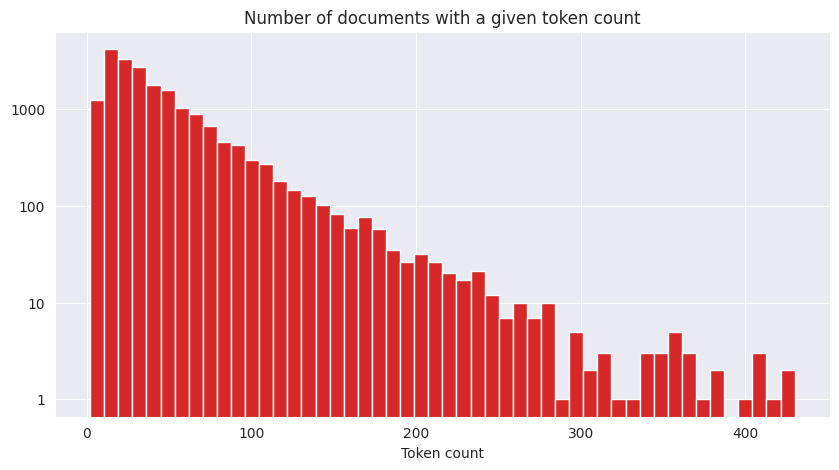

In [5]:
# Get the token counts of each document
df['token_count'] = df['lemmatized_text'].apply(len)

# Create fig and subplots
fig, ax = plt.subplots(figsize=(10,5))

# Get the token counts of each document
df['token_count'].plot(kind='hist', bins=50, logy=True, title='Number of documents with a given token count', color=my_palette[0], alpha=1, ax=ax) 

# Clean up x- and y-axes
ax.set_ylabel(None)
ax.set_xlabel('Token count')
ax.yaxis.set_major_formatter(ScalarFormatter())

# Save the figure
plt.savefig(os.path.join(FIGURE_PATH,'token-counts.pdf'), bbox_inches='tight');

In [6]:
# highest token count in corpus
sorted(pd.unique(df['token_count']))[-1]

# fraction of token counts higher than 100
len(df[df['token_count'] > 150])/len(df.index)

430

0.0252

- The highest token count is 430, but only a minor fraction (2.5 %) of reviews have a token count past 150
- Fixing the sequence length at 150 will result in minor loss of information, but the benift will be a much smaller dataset, faster processing times, and faster model training/evaluation 
- If the token count of a document exceeds this length, take the last 150 tokens, else, pad the front of the sequence with empty M-dimensional vectors

In [7]:
# Set the sequence length
SEQUENCE_LENGTH = 150

## Word2vec model training
- Set a few parameters for encoding the documents:
    - Embedding dimension - length of word embedding vectors
    - Embedding window - number of neighboring words to consider when training word2vec model
    - Minimum word count - minimum occurance of a word to be included in training word2vvec model
    - Sequence length - uniform length of all sequences of word embeddings
- Initialize the word2vec model
- Build the model vocabulary by adding the sentences
- Train the model on the sentence data in 10 epochs

In [8]:
# Set parameters for the word embeddings
EMBEDDING_DIM = 100
EMBEDDING_WINDOW = 5
MIN_WORD_COUNT = 1

# Initialize the word2vec model
w2v_model = Word2Vec(vector_size=EMBEDDING_DIM, window=EMBEDDING_WINDOW, min_count=MIN_WORD_COUNT, workers=4)

# Build the vocabulary with the text corpus
w2v_model.build_vocab(sents_df['lemmatized_sents'], update=False)

# Train the word2vec model to generate word embeddings
w2v_model.train(corpus_iterable=sents_df['lemmatized_sents'], epochs=10, total_examples=len(sents_df.index))

(15230032, 22924080)

- Gensim proves some helpful functions to compare word meanings based on their embedding
- Assess the performance of the model by checking a few words

In [9]:
# Perform some tests on the word embeddings with a few examples
wv = w2v_model.wv
wv['good']
wv.most_similar('good')
wv.most_similar('bad')
wv.most_similar('restaurant')
wv.similarity('good','bad')
wv.similarity('restaurant','jump')

array([ 5.97337961e-01,  3.30244541e-01,  2.39597484e-01,  2.58265465e-01,
        1.66178215e+00,  3.76272678e-01, -1.58987194e-01, -6.27413616e-02,
       -3.67194086e-01,  2.38218620e-01, -1.07715559e+00,  7.47802496e-01,
       -4.52315688e-01,  1.38556308e-04, -1.60039973e+00,  1.48787963e+00,
       -1.47396564e+00,  2.60944510e+00, -2.69757342e+00, -3.74720365e-01,
       -2.00240541e+00, -1.18683195e+00,  1.21923518e+00, -1.82842290e+00,
        5.85669339e-01,  2.32194677e-01, -8.87026072e-01, -2.54165024e-01,
       -1.18954279e-01,  1.73880231e+00, -1.49410498e+00, -1.47869098e+00,
       -1.06925166e+00, -9.83426161e-03,  4.75400656e-01,  1.86475873e+00,
        2.11695862e+00,  3.33883315e-01,  2.49508247e-01, -7.93465495e-01,
        3.66053998e-01, -1.26209760e+00,  2.65388918e+00,  1.03530698e-01,
       -3.81376207e-01, -4.84569597e+00, -5.90450227e-01,  7.27384150e-01,
       -9.04798329e-01, -6.08652294e-01, -9.46153045e-01,  4.00225252e-01,
        1.25439307e-02,  

[('decent', 0.7359878420829773),
 ('bad', 0.6571768522262573),
 ('solid', 0.6449238061904907),
 ('great', 0.6385779976844788),
 ('tasty', 0.5970249772071838),
 ('strange', 0.5580790042877197),
 ('yummy', 0.5492039918899536),
 ('weak', 0.5404806733131409),
 ('disappointing', 0.5308542847633362),
 ('stellar', 0.5254454612731934)]

[('terrible', 0.6604439616203308),
 ('good', 0.6571769118309021),
 ('horrible', 0.6353463530540466),
 ('decent', 0.5140729546546936),
 ('disappointing', 0.5124413967132568),
 ('weird', 0.5031316876411438),
 ('stellar', 0.502001166343689),
 ('strange', 0.4985046684741974),
 ('poor', 0.4874097406864166),
 ('sad', 0.48371779918670654)]

[('place', 0.7591827511787415),
 ('establishment', 0.6715901494026184),
 ('diner', 0.6544526219367981),
 ('location', 0.6231906414031982),
 ('cafe', 0.6071848273277283),
 ('hotel', 0.5979086756706238),
 ('store', 0.5908475518226624),
 ('cuisine', 0.5742629766464233),
 ('joint', 0.5631172060966492),
 ('market', 0.5446036458015442)]

0.6571769

0.07434887

## Document encoding
- With the word2vec model validated we can begin converting the lemmatized tokens in each review document
- We need a function that converts a document to a sequence (numpy array) of word embedding vectors, and pads the array up to the maximum sequence length

In [10]:
# Define a function to encode the text with word embeddings and pad the text if needed
def get_embeddings(text: list[str], embedding_model: KeyedVectors, length: int) -> ndarray[float]:
    '''Encode text using the word2vec and return a padded numpy array with fixed length.'''
    embedding_array = np.array([embedding_model[lemma] for lemma in text[-length:] if lemma in embedding_model])
    padding = length - len(embedding_array)
    padded_array = np.pad(array=embedding_array, pad_width=((padding,0),(0,0)), mode='constant')
    return padded_array

- Now I'll encode every review document in the dataframe and add it as a new column titled 'word_embeddings'
- I'll also check that the shape and contents of an encoded document are as expected

In [11]:
# Get the word embeddings for each review and add to the df
df['word_embeddings'] = df['lemmatized_text'].progress_apply(get_embeddings, embedding_model=wv, length=SEQUENCE_LENGTH)
np.info(df['word_embeddings'][0])
df['word_embeddings'][0]

100%|██████████| 20000/20000 [00:04<00:00, 4166.03it/s]

class:  ndarray
shape:  (150, 100)
strides:  (400, 4)
itemsize:  4
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x571048566860
byteorder:  little
byteswap:  False
type: float32


array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.32324094,  0.01484888,  2.089285  , ...,  0.476566  ,
         0.17368843,  1.6834764 ],
       [-1.0525519 ,  1.1923931 , -1.1976798 , ..., -1.6326193 ,
         0.72020745, -0.7186232 ],
       [ 2.323171  , -0.8698346 , -0.880878  , ..., -0.6055696 ,
        -0.5851423 , -0.3708591 ]], dtype=float32)

# Label Encoding

## Data exploration - classes

- In order to train and evaluate a sentiment classifier, we need a metric for the sentiment of a document
- The review's star rating can be used to separate the documents into separate classes
- A simple approach is to have each star rating represent a unique class that could be interpreted as a sentiment scale from "very negative" to "negative" to "neutral" to "positive" to "very positive" (corresponding to 1, 2, 3, 4, and 5 stars respectively)
- Another approach would be to group data into two classes having "positive" or "negative" sentiment, where a "positive" sentiment could be defined as having 4 or 5 stars, and a "negative" sentiment having 1, 2, or 3 stars
- Lets inspect the distribution of star ratings to inform the decision


In [12]:
# Check the indexing of the class labels ("stars")
sorted(pd.unique(df['stars']))
len(pd.unique(df['stars']))

[1, 2, 3, 4, 5]

5

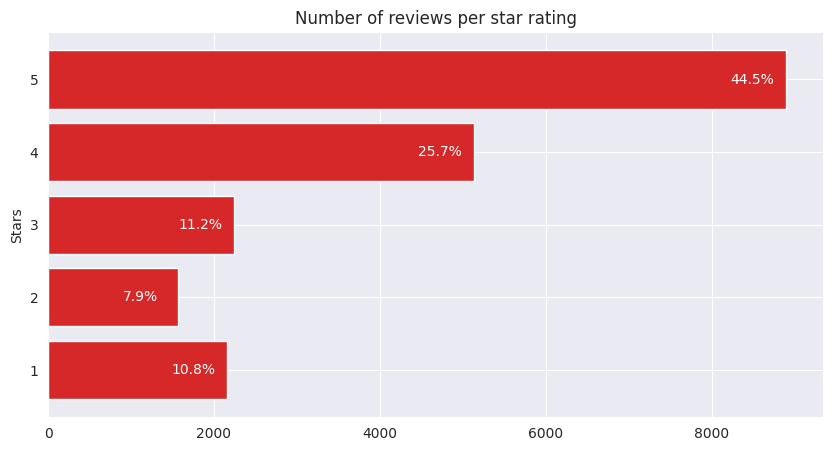

In [13]:
# Inspect the distribution of classes in the dataset
df_counts = df['stars'].value_counts().sort_index()
df_fracs = df['stars'].value_counts(normalize=True).sort_index()

# Inspect the distribution of classes in the dataset
ax = df_counts.plot(figsize=(10,5), kind='barh', width=.8, title='Number of reviews per star rating')

# Annotate bars with the percentage
percent_labels = [f'{100*p:.1f}%' for p in df_fracs]
ax.bar_label(ax.containers[0], labels=percent_labels, label_type='edge', fontsize=10, color='white', padding=-40)

# Clean up y-axis
ax.set(xlabel=None)
ax.set(ylabel='Stars')

# Save figure
plt.savefig(os.path.join(FIGURE_PATH,'star-counts.pdf'), bbox_inches='tight');

- We can see that there are 5 possible values ranging from 1 to 5 for each review
- We will go with the binary approach for three reasons:
    - A binary classifier is easier to train and will generally perform better
    - This makes the model more flexible in interpreting text that does not conform to a 5-star rating scale (i.e., the model will be more flexible in classifying new documents from different datasets)
    - Based on reading a subsample of the reviews and on the distribution of star ratings, few are truely neutral; most reviews are essentially just postive or negative with minor qualifiers

## Feature creation - class labels

- Divide the data into positive and negative classes based off a 1-3 star rating and a 4-5 star rating, respectively
- Add a labels column to the df and specify the class to which the data belong as the values

In [14]:
# Group the data into two subsets: data with a stars value of 1, 2, or 3 in the "negative" subset and data with a stars value of 4 or 5 in the "positive" subset
# Create a new column labeled "label" with values "positive" or "negative" 
df['label'] = np.where(df['stars'] <= 3, 'negative', 'positive')
df['label'].value_counts(ascending=True)
df.head()

label
negative     5969
positive    14031
Name: count, dtype: int64

,stars,lemmatized_text,token_count,word_embeddings,label
0,3,"[decide, eat, aware, go, about 2 hour, begin, ...",38,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",negative
1,5,"[take, lot, spin, class, the year, compare, cl...",66,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",positive
2,3,"[family, diner, buffet, eclectic, assortment, ...",34,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",negative
3,5,"[wow, yummy, different, delicious, favorite, l...",20,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",positive
4,4,"[cute, interior, owner, give, tour, upcoming, ...",53,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",positive


## One-hot encoding

- I still need to encode the class labels numerically so they can be interpreted by a statistical model
- Since the classification is binary we could have a 0/1 or -1/1 represent negative/positive classes, respectively
- Even better is a one-hot encoding, since we do not want to treat the classes as hierarchical


In [15]:
def encode_onehot(label: str) -> ndarray[float]:
    '''Returns a one-hot encoded numpy array based on the sentiment label.'''
    onehot_array = np.zeros(2)
    if label == 'positive': 
        onehot_array[0] = 1.0
    if label == 'negative': 
        onehot_array[1] = 1.0
    return onehot_array

In [16]:
# Create a one-hot encoding for the class labels
# An array = [1, 0] if positive
# An array = [0, 1] if negative
df['onehot_label'] = df['label'].progress_apply(encode_onehot)
np.info(df['onehot_label'][0])
df.head()

100%|██████████| 20000/20000 [00:00<00:00, 509924.08it/s]


class:  ndarray
shape:  (2,)
strides:  (8,)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  True
data pointer: 0x571047667250
byteorder:  little
byteswap:  False
type: float64


,stars,lemmatized_text,token_count,word_embeddings,label,onehot_label
0,3,"[decide, eat, aware, go, about 2 hour, begin, ...",38,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",negative,"[0.0, 1.0]"
1,5,"[take, lot, spin, class, the year, compare, cl...",66,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",positive,"[1.0, 0.0]"
2,3,"[family, diner, buffet, eclectic, assortment, ...",34,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",negative,"[0.0, 1.0]"
3,5,"[wow, yummy, different, delicious, favorite, l...",20,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",positive,"[1.0, 0.0]"
4,4,"[cute, interior, owner, give, tour, upcoming, ...",53,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",positive,"[1.0, 0.0]"


# Data Reduction - Feature Removal

- We are going to separate out the lemmatized text to use when evaluating the model
- For the encoded data, drop the following irrelavent features:
    - 'lemmatized_text'
    - 'token_count'
    - 'stars'
    - 'label'

In [17]:
df_encoded = df.drop(columns=['lemmatized_text','token_count', 'stars', 'label'])
df_encoded.head()

,word_embeddings,onehot_label
0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 1.0]"
1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1.0, 0.0]"
2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 1.0]"
3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1.0, 0.0]"
4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1.0, 0.0]"


- For the lemmatized data, we don't need the word_embeddings
- Drop the following features:
    - 'encoded_text'
    - 'token_count'
    - 'stars'
    - 'label'

In [18]:
df_lemmatized = df.drop(columns=['word_embeddings','token_count', 'stars', 'label'])
df_lemmatized.head()

,lemmatized_text,onehot_label
0,"[decide, eat, aware, go, about 2 hour, begin, ...","[0.0, 1.0]"
1,"[take, lot, spin, class, the year, compare, cl...","[1.0, 0.0]"
2,"[family, diner, buffet, eclectic, assortment, ...","[0.0, 1.0]"
3,"[wow, yummy, different, delicious, favorite, l...","[1.0, 0.0]"
4,"[cute, interior, owner, give, tour, upcoming, ...","[1.0, 0.0]"


# Save Processed and Interim Data

- I can now save the encoded text data and lemmatized data as separate output files for model training and evaluation
- I am saving the data in the JSON format to remain consistent with the input files

In [19]:
# The text data are now encoded as uniform sequences of word embeddings
# The next step will be to train the learning model
# Save the current state of the data so it can be read by other notebooks
df_encoded.to_json(os.path.join(PROC_DATA_PATH, 'encoded-data.json'), orient='records', lines=True)

# Save the original lemmatized text data for evaluating the trained model
df_lemmatized.to_json(os.path.join(INT_DATA_PATH, 'lemmatized-labeled-data.json'), orient='records', lines=True)

In [20]:
# Read the saved data back in to verify the format
df_encoded = pd.read_json(os.path.join(PROC_DATA_PATH, 'encoded-data.json'), orient='records', lines=True)

# Inspect the size and data-types of the df
df_encoded.info()

# Inspect the first few rows
df_encoded.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   word_embeddings  20000 non-null  object
 1   onehot_label     20000 non-null  object
dtypes: object(2)
memory usage: 312.6+ KB


,word_embeddings,onehot_label
0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 1.0]"
1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1.0, 0.0]"
2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 1.0]"
3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1.0, 0.0]"
4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1.0, 0.0]"


In [21]:
# Read the saved data back in to verify the format
df_lemmatized = pd.read_json(os.path.join(INT_DATA_PATH, 'lemmatized-labeled-data.json'), orient='records', lines=True)

# Inspect the size and data-types of the df
df_lemmatized.info()

# Inspect the first few rows
df_lemmatized.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   lemmatized_text  20000 non-null  object
 1   onehot_label     20000 non-null  object
dtypes: object(2)
memory usage: 312.6+ KB


,lemmatized_text,onehot_label
0,"[decide, eat, aware, go, about 2 hour, begin, ...","[0.0, 1.0]"
1,"[take, lot, spin, class, the year, compare, cl...","[1.0, 0.0]"
2,"[family, diner, buffet, eclectic, assortment, ...","[0.0, 1.0]"
3,"[wow, yummy, different, delicious, favorite, l...","[1.0, 0.0]"
4,"[cute, interior, owner, give, tour, upcoming, ...","[1.0, 0.0]"
